In [1]:
# Prepare environment to import files
import prepare_notebook 

Dodano do ścieżki: /home/edwinh/drone-swarm-simulation


In [2]:
# World generation imports
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from typing import NamedTuple, Literal, Callable, Optional, Protocol, Dict, Any, List
from numpy.typing import NDArray
from src.environments.abstraction.generate_obstacles import generate_obstacles, ObstaclesData, strategy_random_uniform, strategy_grid_jitter
from src.environments.abstraction.generate_world_boundaries import generate_world_boundaries, WorldData

# Trajectory counting imports
from src.algorithms.abstraction.count_trajectories import count_trajectories
from src.algorithms.abstraction.trajectory.strategies.linear_trajectory import linear_trajectory
from src.algorithms.abstraction.trajectory.strategies.nsga3_swarm_strategy import nsga3_swarm_strategy

# Ustawienie ziarna losowości dla powtarzalności wyników
np.random.seed(40)

print("Biblioteki załadowane.")

pybullet build time: Jan 29 2025 23:16:28
/home/edwinh/miniconda3/envs/drone-swarm-env/lib/python3.10/site-packages/gym_pybullet_drones/control/BaseControl.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Biblioteki załadowane.


In [3]:
# utils for drawing things
def plot_world_scenario(world: WorldData, obstacles_list: list[ObstaclesData], title="World Scenario"):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Rysowanie granic świata (Wireframe Box)
    mx, my, mz = world.max_bounds
    # ... (kod rysowania pudełka świata - uprośćmy do osi)
    
    colors = {'CYLINDER': 'red', 'BOX': 'blue'}
    
    print(f"Rysowanie świata: {mx}x{my}x{mz}m")
    
    for obs_batch in obstacles_list:
        data = obs_batch.data
        shape = obs_batch.shape_type
        print(f" -> Batch: {shape}, Count: {obs_batch.count}")
        
        for i in range(obs_batch.count):
            x, y, z, d1, d2, d3 = data[i]
            
            if shape == 'CYLINDER':
                # d1=radius, d2=height
                draw_cylinder(ax, x, y, d1, d2, color=colors[shape])
            elif shape == 'BOX':
                # d1=len, d2=wid, d3=height
                draw_box(ax, x, y, d1, d2, d3, color=colors[shape])

    # Ustawienia osi
    ax.set_xlabel('X [m]')
    ax.set_ylabel('Y [m]')
    ax.set_zlabel('Z [m]')
    ax.set_title(title)
    ax.set_xlim(0, mx)
    ax.set_ylim(0, my)
    ax.set_zlim(0, mz)
    ax.set_box_aspect([mx, my, mz]) 
    plt.show()

# --- Pomocnicze funkcje rysujące (znane z wcześniejszych kroków) ---
def draw_cylinder(ax, x, y, r, h, color='red'):
    z = np.linspace(0, h, 10)
    theta = np.linspace(0, 2*np.pi, 15)
    theta_grid, z_grid = np.meshgrid(theta, z)
    x_grid = x + r * np.cos(theta_grid)
    y_grid = y + r * np.sin(theta_grid)
    ax.plot_surface(x_grid, y_grid, z_grid, color=color, alpha=0.3)

def draw_box(ax, x, y, l, w, h, color='blue'):
    # Proste rysowanie pudełka jako wireframe lub punktów (dla szybkości w matplotlib)
    # Rysujemy środek podstawy + wysokość
    ax.bar3d(x - l/2, y - w/2, 0, l, w, h, color=color, alpha=0.3, edgecolor='k')


In [4]:
# world generation
#### 1. Definiujemy Świat
"""
  city_length: 1000.0
  city_width: 300.0
  block_size: 30.0
  street_width: 10.0
  min_height: 15.0
  max_height: 60.0
  skyscraper_prob: 0.15
"""
world_def = generate_world_boundaries(width=300.0, length=1000.0, height=100.0, ground_height=0.1)

In [5]:
# algorithm parameters preparation
n_waypoints = 100       # Liczba punktów trasy
drone_swarm_size = 5    # Wielkość roju

# drones positions
center_x = world_def.center[0]
spacing_x = 5.0
start_xs = np.linspace(center_x - (spacing_x * (drone_swarm_size // 2)), 
                       center_x + (spacing_x * (drone_swarm_size // 2)), 
                       drone_swarm_size)

# sligthly minus to avoid obstacles in the start
start_y_value = 1.0
start_ys = np.full(drone_swarm_size, start_y_value)

# start from the ground
start_zs = np.full(drone_swarm_size, 0.5)

# Compounding to tensor (N, 3)
start_positions = np.column_stack((start_xs, start_ys, start_zs)).astype(np.float64)

# Target 
target_y_value = world_def.max_bounds[1] - 1  # Koniec mapy w Y
target_z_value = 10.0
target_xs = start_xs
target_ys = np.full(drone_swarm_size, target_y_value)
target_zs = np.full(drone_swarm_size, target_z_value)

target_positions = np.column_stack((target_xs, target_ys, target_zs)).astype(np.float64)
print("Przykładowe pozycje startowe (X, Y, Z):\n", start_positions)
print("Przykładowe pozycje celu (X, Y, Z): \n", target_positions)



Przykładowe pozycje startowe (X, Y, Z):
 [[140.    1.    0.5]
 [145.    1.    0.5]
 [150.    1.    0.5]
 [155.    1.    0.5]
 [160.    1.    0.5]]
Przykładowe pozycje celu (X, Y, Z): 
 [[140. 999.  10.]
 [145. 999.  10.]
 [150. 999.  10.]
 [155. 999.  10.]
 [160. 999.  10.]]


Rysowanie świata: 300.0x1000.0x100.0m
 -> Batch: BOX, Count: 63


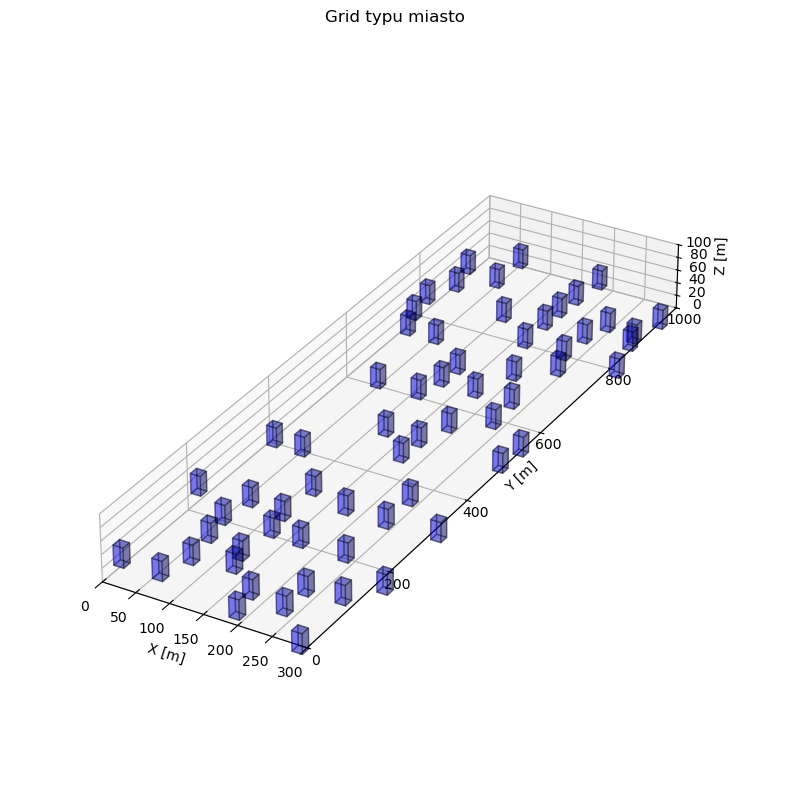

In [30]:

# 2. Generujemy Miasto (Pudełka w siatce)
city_grid = generate_obstacles(
    world_def,
    n_obstacles=63,
    shape_type='BOX',
    placement_strategy=strategy_grid_jitter,
    size_params={'length': 15.0, 'width': 15.0, 'height': 30.0},
    start_positions=start_positions,
    target_positions=target_positions
)

# 4. Wizualizacja obu zestawów naraz
plot_world_scenario(world_def, [city_grid], title="Grid typu miasto")


In [31]:
# counting trajectories with linear method

generated_trajectories = count_trajectories(
    world_data=world_def,
    obstacles_data=city_grid,
    counting_protocol=linear_trajectory,  # Przekazujemy funkcję strategii
    drone_swarm_size=drone_swarm_size,
    number_of_waypoints=n_waypoints,
    start_positions=start_positions,
    target_positions=target_positions,
    algorithm_params=None
)

In [32]:
# --- 3. Wizualizacja trajektorii 3D (Zoptymalizowana pod NSGA-III) ---
def plot_world_scenario_with_trajectories(
    world: WorldData, 
    obstacles_list: List[ObstaclesData], 
    trajectories: Optional[Any] = None, # Zmieniono typ na Any dla elastyczności
    start_positions: Optional[NDArray[np.float64]] = None,
    target_positions: Optional[NDArray[np.float64]] = None,
    title="Symulacja Roju Dronów"
):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # --- 1. Rysowanie granic świata ---
    mx, my, mz = world.max_bounds
    ax.plot([0, mx, mx, 0, 0], [0, 0, my, my, 0], [0, 0, 0, 0, 0], 'k--', alpha=0.3)
    ax.plot([0, mx, mx, 0, 0], [0, 0, my, my, 0], [mz, mz, mz, mz, mz], 'k--', alpha=0.3)
    
    # --- 2. Rysowanie przeszkód ---
    colors = {'CYLINDER': 'red', 'BOX': 'blue'}
    print(f"Rysowanie świata: {mx}x{my}x{mz}m")
    
    for obs_batch in obstacles_list:
        data = obs_batch.data
        shape = obs_batch.shape_type
        print(f" -> Batch: {shape}, Count: {obs_batch.count}")
        for i in range(obs_batch.count):
            x, y, z, d1, d2, d3 = data[i]
            if shape == 'CYLINDER':
                draw_cylinder(ax, x, y, d1, d2, color=colors.get(shape, 'red'))
            elif shape == 'BOX':
                draw_box(ax, x, y, d1, d2, d3, color=colors.get(shape, 'blue'))

    # --- 3. Rysowanie Trajektorii (POPRAWKA) ---
    if trajectories is not None:
        # === KLUCZOWA ZMIANA: Normalizacja danych ===
        # NSGA-III zwraca (N_drones, N_steps, 3) jako ndarray.
        # Upewniamy się, że mamy taki format, nawet jak przyjdzie lista.
        try:
            trajs_np = np.array(trajectories)
            if trajs_np.ndim != 3 or trajs_np.shape[2] != 3:
                 print(f"UWAGA: Nieprawidłowy kształt trajektorii: {trajs_np.shape}. Oczekiwano (N, Steps, 3).")
                 return
        except Exception as e:
            print(f"Błąd konwersji trajektorii: {e}")
            return

        num_drones = trajs_np.shape[0]
        steps = trajs_np.shape[1]
        print(f" -> Rysowanie tras dla {num_drones} dronów (każda ma {steps} punktów)")

        colors_traj = plt.cm.jet(np.linspace(0, 1, num_drones))
        
        for i in range(num_drones):
            # Tu używamy już bezpiecznej tablicy 'trajs_np'
            path = trajs_np[i]
            xs, ys, zs = path[:, 0], path[:, 1], path[:, 2]
            
            # Rysowanie ciągłej linii (B-Spline jest gęsty, więc plot wygląda dobrze)
            ax.plot(xs, ys, zs, color=colors_traj[i], linewidth=2, label=f'Dron {i}', alpha=0.8)
            
            # Start
            if start_positions is not None and i < len(start_positions):
                sx, sy, sz = start_positions[i]
                ax.scatter(sx, sy, sz, color='green', marker='o', s=40, zorder=10)
            
            # Cel
            if target_positions is not None and i < len(target_positions):
                # Obsługa przypadku, gdy target_positions to (1,3) lub (N,3)
                if target_positions.ndim == 1: 
                    tx, ty, tz = target_positions
                else:
                    tx, ty, tz = target_positions[i]
                ax.scatter(tx, ty, tz, color='red', marker='x', s=40, linewidth=2, zorder=10)

    # --- 4. Ustawienia widoku ---
    ax.set_xlabel('X [m]')
    ax.set_ylabel('Y [m]')
    ax.set_zlabel('Z [m]')
    ax.set_title(title)
    ax.set_xlim(0, mx)
    ax.set_ylim(0, my)
    ax.set_zlim(0, mz)
    
    try:
        ax.set_box_aspect([mx, my, mz])
    except:
        pass

    if trajectories is not None:
        ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
        
    plt.show()


Rysowanie świata: 300.0x1000.0x100.0m
 -> Batch: BOX, Count: 63
 -> Rysowanie tras dla 5 dronów (każda ma 100 punktów)


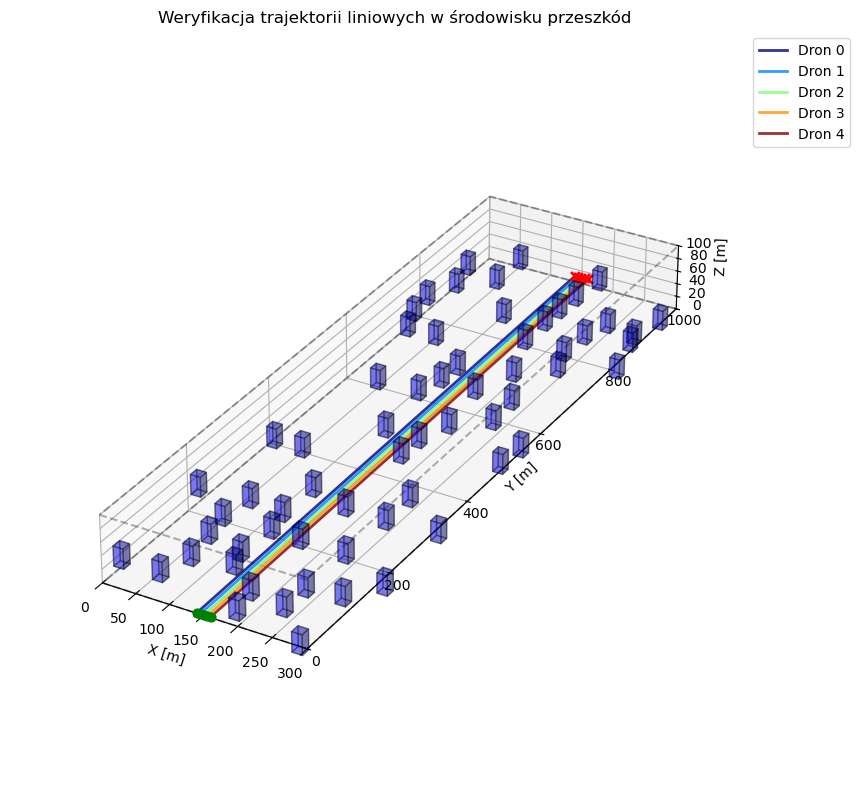

In [33]:
# Wyśweitelenie wykresu
plot_world_scenario_with_trajectories(
    world=world_def,
    obstacles_list=[city_grid],  # Przekazujemy jako listę, bo tak masz w pętli
    trajectories=generated_trajectories,
    start_positions=start_positions,
    target_positions=target_positions,
    title="Weryfikacja trajektorii liniowych w środowisku przeszkód"
)

In [34]:
# nsga3 test
# ==========================================
# CZĘŚĆ 2: TESTOWANIE STRATEGII NSGA-III (GPU/CPU)
# ==========================================

# 1. Import nowej strategii ewolucyjnej
# Upewnij się, że pliki stworzone w poprzednich krokach znajdują się w folderze src/strategies/nsga3_components/
try:
    from src.algorithms.abstraction.trajectory.strategies.nsga3_utils.swarm_evolution_strategy import nsga3_swarm_strategy
    print("✅ Pomyślnie zaimportowano moduł NSGA-III Swarm Strategy.")
except ImportError as e:
    print(f"❌ Błąd importu strategii NSGA-III: {e}")
    print("Upewnij się, że w folderze 'src/strategies/nsga3_components/' znajduje się pusty plik '__init__.py'")
    # Jeśli pracujesz w notebooku i właśnie dodałeś pliki, może być konieczny restart kernela.

#

✅ Pomyślnie zaimportowano moduł NSGA-III Swarm Strategy.


In [39]:
# #2. Konfiguracja parametrów algorytmu
# Tutaj definiujemy "charakter" naszego roju
evo_params = {
    "pop_size": 200,                # Wielkość populacji (na GPU można dać więcej)
    "n_gen": 100,                   # Liczba generacji
    
    # --- ZMIANA LOGIKI (B-Spline -> Polyline) ---
    # Zamiast 'n_control_points' używamy 'n_inner_waypoints'.
    # Określa to, ile punktów pośrednich algorytm może przesuwać.
    # Dla prostych omijań 3-5 wystarczy.
    "n_inner_waypoints": 5,         
    
    "decision_mode": "safety",  # Tryb decydenta
    "min_dist": 1.5,                # Bezpieczny dystans między dronami [m]
    "ignore_ratio": 0.1,            # Ignorowanie kolizji przy samym starcie/lądowaniu
    
    # --- NOWE PARAMETRY GEOMETRYCZNE (Dla Łamanej) ---
    "uniformity_std": 5.0,          # Wymuszenie równych odstępów (im mniej, tym punkty równiej rozłożone)
    "max_jerk": 200.0               # Wymuszenie gładkości (im mniej, tym mniej ostrych zakrętów)
}

print(f"\n🚀 Uruchamianie symulacji NSGA-III (Polyline Mode)...")
print(f"   Parametry: {evo_params}")
# ... (reszta printów bez zmian) ...


# 3. Uruchomienie obliczeń
# Funkcja count_trajectories przekaże nowe parametry do strategii
nsga3_trajectories = count_trajectories(
    world_data=world_def,
    obstacles_data=[city_grid], 
    counting_protocol=nsga3_swarm_strategy,
    drone_swarm_size=drone_swarm_size,
    number_of_waypoints=n_waypoints,
    start_positions=start_positions,
    target_positions=target_positions,
    algorithm_params=evo_params
)

# 4. Weryfikacja wyników
if np.all(nsga3_trajectories == 0):
    print("⚠️ OSTRZEŻENIE: Algorytm zwrócił same zera.")
else:
    print("✅ Obliczenia zakończone sukcesem.")
    
    # Szybka diagnostyka zakotwiczenia (czy start i meta się zgadzają)
    start_err = np.linalg.norm(nsga3_trajectories[:, 0] - start_positions)
    end_err = np.linalg.norm(nsga3_trajectories[:, -1] - target_positions)
    
    if start_err < 1.0 and end_err < 1.0:
         print(f"   [OK] Trasa poprawnie zakotwiczona (Start/Cel err: {start_err:.2f}/{end_err:.2f})")
    else:
         print(f"   [WARN] Trasa oderwana od punktów! (Start err: {start_err:.2f}, End err: {end_err:.2f})")

    # Statystyki długości
    diffs = np.diff(nsga3_trajectories, axis=1)
    dists = np.sqrt(np.sum(diffs**2, axis=-1))
    total_len = np.sum(dists)
    print(f"   Łączna długość tras roju: {total_len:.2f} m")



🚀 Uruchamianie symulacji NSGA-III (Polyline Mode)...
   Parametry: {'pop_size': 200, 'n_gen': 100, 'n_inner_waypoints': 5, 'decision_mode': 'safety', 'min_dist': 1.5, 'ignore_ratio': 0.1, 'uniformity_std': 5.0, 'max_jerk': 200.0}
[NSGA-III Polyline] Start. Pop: 200 (Ref: 210), Gen: 100, Inner Pts: 5
[Problem] Liczba zmiennych: 75
[Problem] Granice X: -50.0 350.0
This might cause unwanted behavior of the algorithm. 
Please make sure pop_size is equal or larger than the number of reference directions. 
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      200 |      1 |  6.629019E+02 |  7.213038E+02 |             - |             -
     2 |      400 |      1 |  1.106903E+02 |  6.939743E+02 |             - |             -
     3 |      600 |      1 |  1.106903E+02 |  6.686870E+02 |             - |             -
     4 |      800 |      1 |  1.019174E+02 |  6.349439E+02 |             - |             -
     5 |     1000 |      1 |  1.172487

Rysowanie świata: 300.0x1000.0x100.0m
 -> Batch: BOX, Count: 63
 -> Rysowanie tras dla 5 dronów (każda ma 100 punktów)


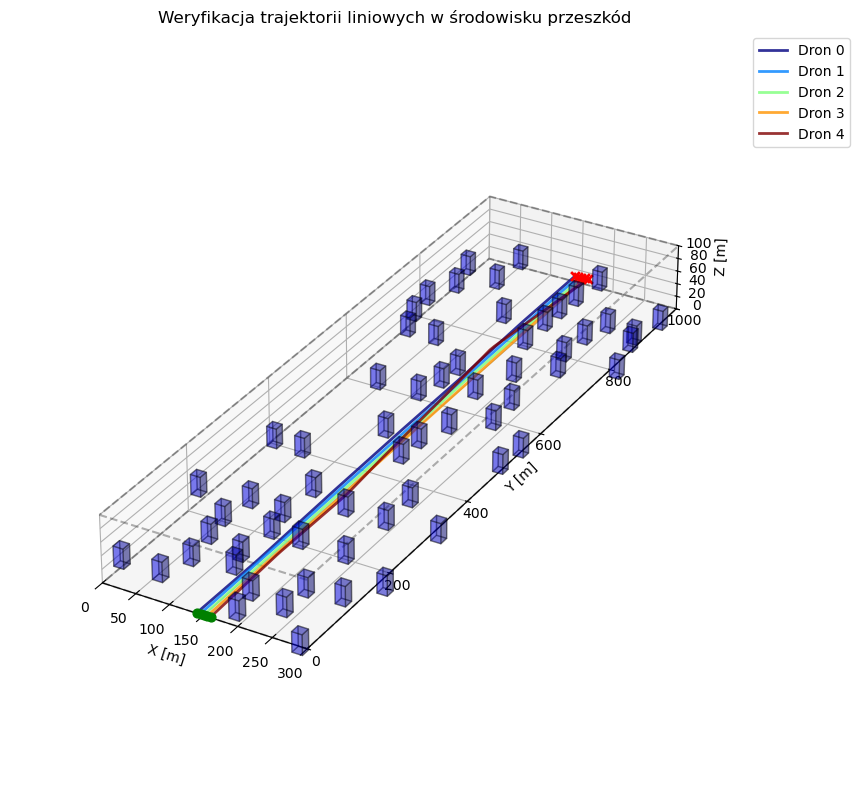

In [40]:
# Wyśweitelenie wykresu
plot_world_scenario_with_trajectories(
    world=world_def,
    obstacles_list=[city_grid],  # Przekazujemy jako listę, bo tak masz w pętli
    trajectories=nsga3_trajectories,
    start_positions=start_positions,
    target_positions=target_positions,
    title="Weryfikacja trajektorii liniowych w środowisku przeszkód"
)

In [41]:
import numpy as np

# Załóżmy, że zmienna z wynikiem to 'nsga3_trajectories'
print("=== DIAGNOSTYKA TRAJEKTORII NSGA-III ===")

# 1. Sprawdzenie typu i kształtu
print(f"Typ danych: {type(nsga3_trajectories)}")
if isinstance(nsga3_trajectories, np.ndarray):
    print(f"Kształt (Shape): {nsga3_trajectories.shape}")
    print(f"Typ elementów: {nsga3_trajectories.dtype}")
elif isinstance(nsga3_trajectories, list):
    print(f"Długość listy: {len(nsga3_trajectories)}")
    if len(nsga3_trajectories) > 0:
        print(f"Typ pierwszego elementu: {type(nsga3_trajectories[0])}")
        if hasattr(nsga3_trajectories[0], 'shape'):
             print(f"Kształt pierwszego elementu: {nsga3_trajectories[0].shape}")

# 2. Analiza wartości (Szukanie problemu skali)
# Konwersja do numpy dla łatwiejszej analizy
try:
    traj_np = np.array(nsga3_trajectories)
    
    min_val = np.min(traj_np)
    max_val = np.max(traj_np)
    mean_val = np.mean(traj_np)
    
    print(f"\nZakres wartości w danych:")
    print(f"Min: {min_val:.4f}")
    print(f"Max: {max_val:.4f}")
    print(f"Średnia: {mean_val:.4f}")
    
    # Sprawdzenie czy dane są w zakresie [0, 1] (typowe dla surowego wyniku algorytmu)
    if max_val <= 1.5:
        print("\n[ALARM] Wartości są bardzo małe (< 1.5).")
        print("Prawdopodobna przyczyna: Algorytm zwraca znormalizowane współrzędne [0,1], a nie metry.")
    elif max_val > 100:
        print("\n[OK] Wartości wyglądają na przeskalowane do świata rzeczywistego (> 100).")
        
    # Sprawdzenie czy Start i Koniec pasują do oczekiwań
    # Zakładamy, że pierwszy dron startuje z okolic [140, 1, 0.5]
    start_pt = traj_np[0, 0, :]
    end_pt = traj_np[0, -1, :]
    
    print(f"\nPierwszy dron - Punkt Startowy (dane): {start_pt}")
    print(f"Pierwszy dron - Punkt Końcowy (dane): {end_pt}")
    
except Exception as e:
    print(f"\nBłąd podczas analizy wartości: {e}")


=== DIAGNOSTYKA TRAJEKTORII NSGA-III ===
Typ danych: <class 'numpy.ndarray'>
Kształt (Shape): (5, 100, 3)
Typ elementów: float64

Zakres wartości w danych:
Min: -0.2504
Max: 999.0000
Średnia: 215.3096

[OK] Wartości wyglądają na przeskalowane do świata rzeczywistego (> 100).

Pierwszy dron - Punkt Startowy (dane): [140.    1.    0.5]
Pierwszy dron - Punkt Końcowy (dane): [140. 999.  10.]
